In [1]:
!pip install pykalman

In [2]:
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow keras hmmlearn statsmodels ta transformers torch tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import BayesianGaussianMixture
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


c:\Users\viswa\GithubClonedRepos\PAML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: NI=F"}}}
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NI=F']: YFTzMissingError('possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['NI=F']: YFTzMissingError('possibly delisted; no timezone found')


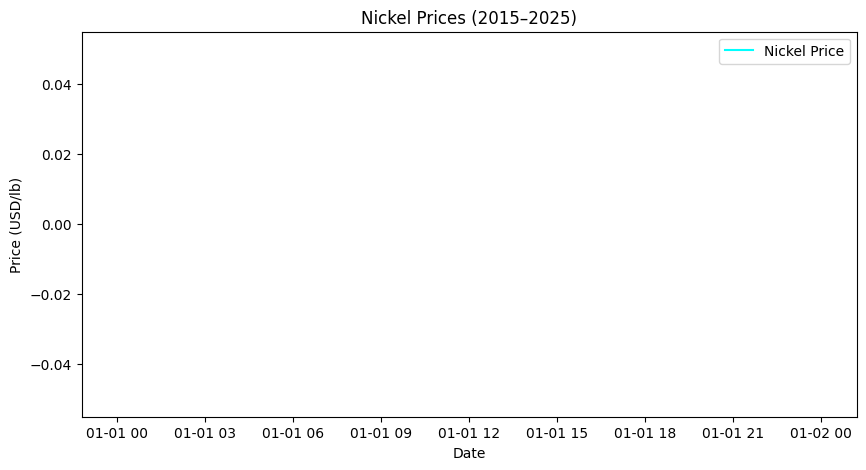

Price,NICKEL
Ticker,NI=F
Date,


In [4]:
# --- Load Nickel Prices ---
df = yf.download("NI=F", start="2015-01-01", end="2025-01-01")  # COMEX Nickel Futures
df = df[["Close"]].rename(columns={"Close": "NICKEL"})
df.dropna(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df["NICKEL"], label="Nickel Price", color='cyan')
plt.title("Nickel Prices (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD/lb)")
plt.legend()
plt.show()

df.head()

In [ ]:
# --- 4. Technical Indicators (RSI, MACD, SMA, EMA) ---

# Ensure the 'NICKEL' column is a 1-D Series
nickel_series = pd.Series(np.ravel(df["NICKEL"].values), index=df.index)

# RSI
df["RSI"] = RSIIndicator(close=nickel_series, window=14).rsi()

# MACD
macd_obj = MACD(close=nickel_series)
df["MACD"] = pd.Series(np.ravel(macd_obj.macd().values), index=df.index)
df["Signal_Line"] = pd.Series(np.ravel(macd_obj.macd_signal().values), index=df.index)

# Moving Averages
df["SMA_20"] = SMAIndicator(close=nickel_series, window=20).sma_indicator()
df["EMA_50"] = EMAIndicator(close=nickel_series, window=50).ema_indicator()

# Clean up
df.dropna(inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df["NICKEL"], label="Nickel", alpha=0.7)
plt.plot(df["SMA_20"], label="SMA 20", linestyle="--")
plt.plot(df["EMA_50"], label="EMA 50", linestyle="--")
plt.title("Nickel Prices with Moving Averages")
plt.legend()
plt.show()

df.tail()

In [ ]:
# --- Kalman Filter Smoothing ---
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=df["NICKEL"].values[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

state_means, _ = kf.filter(df["NICKEL"].values)
df["Kalman_Smoothed"] = state_means

plt.figure(figsize=(10,5))
plt.plot(df["NICKEL"], label="Original", alpha=0.6)
plt.plot(df["Kalman_Smoothed"], label="Kalman Smoothed", color='red')
plt.legend()
plt.title("Kalman Filter Smoothing")
plt.show()

In [ ]:
# --- 6. Hidden Markov Model (HMM) ---

# Ensure the nickel data is 1-D for fitting and plotting
nickel_vals = np.ravel(df["NICKEL"].values)

# Fit the model
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=200)
hmm.fit(nickel_vals.reshape(-1, 1))
hidden_states = hmm.predict(nickel_vals.reshape(-1, 1))

# Store in DataFrame
df["HMM_State"] = hidden_states

# Plot — make sure everything passed to seaborn is 1-D
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=df.index,
    y=np.ravel(df["NICKEL"].values),
    hue=df["HMM_State"],
    palette="coolwarm",
    s=30
)
plt.title("Nickel Price Regimes (HMM States)")
plt.xlabel("Time")
plt.ylabel("Nickel Price (USD/lb)")
plt.show()

In [ ]:
# --- 7. Bayesian Gaussian Mixture (BGM) ---

# Make sure nickel prices are strictly 1-D
nickel_vals = np.ravel(df["NICKEL"].values)

# Fit Bayesian Gaussian Mixture model
bgm = BayesianGaussianMixture(n_components=3, covariance_type="diag", n_init=5)
bgm.fit(nickel_vals.reshape(-1, 1))
bgm_states = bgm.predict(nickel_vals.reshape(-1, 1))

# Store the states in DataFrame
df["BGM_State"] = bgm_states

# Plot regimes — ensure all arrays are 1-D
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.arange(len(nickel_vals)),
    y=nickel_vals,
    hue=df["BGM_State"].astype(int),
    palette="viridis",
    s=30
)
plt.title("Bayesian Gaussian Mixture Market Regimes")
plt.xlabel("Time")
plt.ylabel("Nickel Price (USD/lb)")
plt.show()

In [ ]:
# --- 8. Monte Carlo Simulation for Nickel Prices ---

import numpy as np
import matplotlib.pyplot as plt

# Extract and clean nickel prices
nickel_prices = df["NICKEL"].values.flatten()

# Calculate daily log returns
log_returns = np.diff(np.log(nickel_prices))
mu = np.mean(log_returns)
sigma = np.std(log_returns)

# Simulation parameters
n_simulations = 100     # number of simulated paths
n_days = 60             # days to simulate

# Initialize matrix for simulations
simulations = np.zeros((n_days, n_simulations))

# Run simulations
for sim in range(n_simulations):
    price_series = [nickel_prices[-1]]  # start from last known price
    for day in range(1, n_days + 1):
        # geometric Brownian motion formula
        price = price_series[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
        price_series.append(price)
    # Ensure conversion to numpy array for assignment
    simulations[:, sim] = np.array(price_series[1:])

# Plot all simulated paths
plt.figure(figsize=(10, 5))
plt.plot(simulations, alpha=0.5)
plt.title("Monte Carlo Simulation of Nickel Prices (60 days ahead)")
plt.xlabel("Day")
plt.ylabel("Simulated Price (USD/lb)")
plt.show()

In [ ]:
# --- Jump Diffusion Model ---
mu = df["NICKEL"].pct_change().mean()
sigma = df["NICKEL"].pct_change().std()
S0 = df["NICKEL"].iloc[-1]
jd_prices = jump_diffusion_sim(S0, mu, sigma, lamb=0.1, mu_j=-0.02, sigma_j=0.05)

def jump_diffusion_sim(S0, mu, sigma, lamb, mu_j, sigma_j, T=1, steps=252, n_sims=100):
    dt = T/steps
    prices = np.zeros((steps, n_sims))
    for sim in range(n_sims):
        prices[0, sim] = S0
        for t in range(1, steps):
            N = np.random.poisson(lamb * dt)
            J = np.sum(np.random.normal(mu_j, sigma_j, N))
            drift = (mu - 0.5 * sigma**2) * dt
            diffusion = sigma * np.sqrt(dt) * np.random.normal()
            prices[t, sim] = prices[t-1, sim] * np.exp(drift + diffusion + J)
    return prices

jd_prices = jump_diffusion_sim(S0, mu, sigma, lamb=0.1, mu_j=-0.02, sigma_j=0.05)
plt.figure(figsize=(10,5))
plt.plot(jd_prices, alpha=0.1, color='red')
plt.title("Jump Diffusion Simulations for Nickel Prices")
plt.xlabel("Days")
plt.ylabel("Price (USD/lb)")
plt.show()

In [ ]:
# --- NLTK Sentiment Analysis ---
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

headlines = [
    "Nickel prices surge on EV battery demand",
    "Concerns rise over nickel supply constraints",
    "Global tech slowdown impacts nickel prices",
]

def get_nltk_sentiment(texts):
    sentiments = []
    for text in texts:
        scores = sia.polarity_scores(text)
        compound = scores['compound']
        
        # Classify based on compound score
        if compound >= 0.05:
            sentiment = "Positive"
        elif compound <= -0.05:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"
        sentiments.append(sentiment)
    return sentiments

sentiments = get_nltk_sentiment(headlines)
for h, s in zip(headlines, sentiments):
    print(f"{h} → {s}")

In [ ]:
# --- 9. LSTM Training and Nickel Price Prediction ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --- Prepare Data ---

# Select numerical columns (excluding date if any)
features = df.select_dtypes(include=[np.number]).copy()

# Choose your target column here
target_col = "NICKEL"  # <-- change to "SILVER" later if needed

if target_col not in features.columns:
    raise ValueError(f"{target_col} column not found in dataframe. Available columns: {list(features.columns)}")

# Fill NaN values
features = features.fillna(method='ffill').fillna(method='bfill')

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, features.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

# Split into train/test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Build LSTM Model ---

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# Inverse transform predictions & actuals to original scale
scaler_for_target = MinMaxScaler()
scaler_for_target.fit(features[[target_col]])
y_test_rescaled = scaler_for_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_for_target.inverse_transform(y_pred)

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Nickel Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Nickel Price', color='red', alpha=0.7)
plt.title("LSTM Prediction vs Actual Nickel Price")
plt.xlabel("Time")
plt.ylabel("Nickel Price (USD/lb)")
plt.legend()
plt.show()

# --- RMSE ---
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse:.4f}")
from sklearn.metrics import r2_score

# Calculate R²
#r2 = r2_score(y_test, predicted_prices)
#print(f"R² Score: {r2:.4f}")

In [ ]:
# --- Model Evaluation Metrics ---

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Try to detect prediction variable
try:
    y_pred_eval = predicted_prices
except NameError:
    try:
        y_pred_eval = predictions
    except NameError:
        try:
            y_pred_eval = y_pred
        except NameError:
            raise NameError("Couldn't find prediction variable. Make sure your LSTM cell outputs predictions.")

# Ensure both y_test and predictions are 1D arrays
y_test = np.array(y_test).flatten()
y_pred_eval = np.array(y_pred_eval).flatten()

# Calculate metrics
r2 = r2_score(y_test, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_eval))
mae = mean_absolute_error(y_test, y_pred_eval)

# Print results
print("📊 Model Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")